### Wakefield simulation of accelerator cavity with `wakis`

* EM Simulation of a lossy cylindrical accelerator cavity 
* Calculation of the longitudinal wake potential and impedance
* Plotting in 3d, 2d, 1d of the results

| Geometry  | Wake potential  | Impedance  |
| --- | --- | --- | 
| 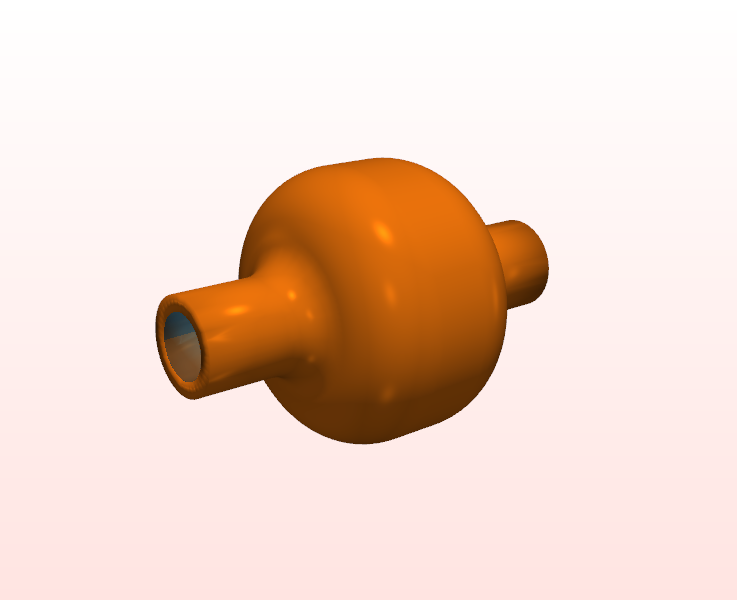 |  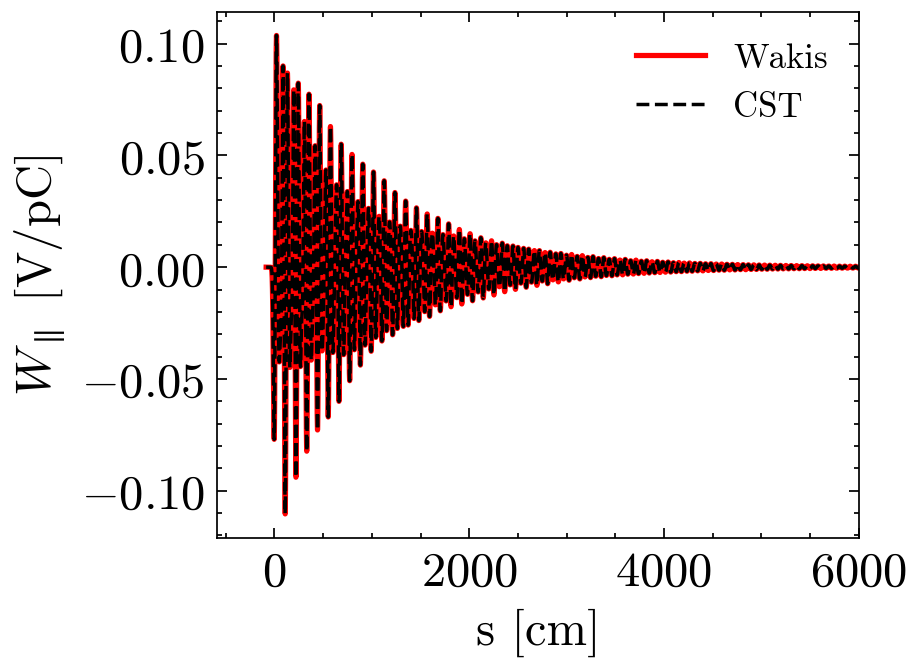  |  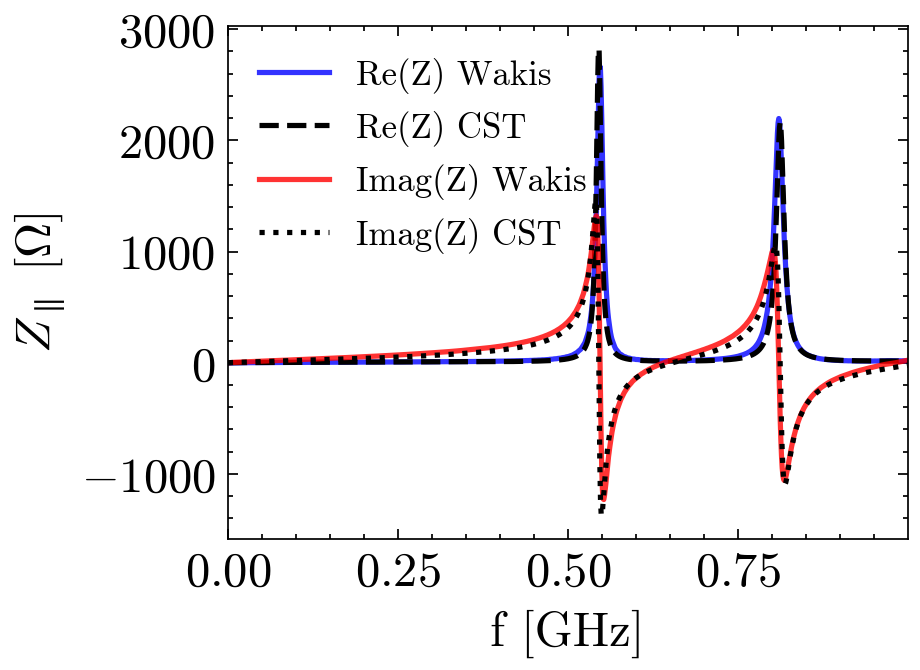   |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv

from wakis import SolverFIT3D
from wakis import GridFIT3D
from wakis import WakeSolver

%matplotlib ipympl

### Domain setup and grid generation

We can read the geometry, stored into `.stl` files, into python with our core dependency package `pyvista`:

In [18]:
# Read geometry -change path if errors are found!
stl_cavity = "data/002_vacuum_cavity.stl"
stl_shell = "data/002_lossymetal_shell.stl"

pl = pv.Plotter()
pl.add_mesh(pv.read(stl_shell), color="tab:orange", specular=0.5, smooth_shading=True)
pl.add_mesh(
    pv.read(stl_cavity),
    color="tab:blue",
    opacity=0.5,
    specular=0.5,
    smooth_shading=True,
)
pl.set_background("mistyrose", top="white")
pl.show()

Widget(value='<iframe src="http://localhost:46189/index.html?ui=P_0x7fdfc8967620_8&reconnect=auto" class="pyvi…

In [3]:
# ---------- Domain setup ---------
# Number of mesh cells
Nx = 100
Ny = 100
Nz = 101
# dt = 2.187760221e-12 # like CST

stl_solids = {"cavity": stl_cavity, "shell": stl_shell}
stl_materials = {"cavity": "vacuum", "shell": [30, 1.0, 30]}

# Domain bounds
surf = pv.read(stl_shell) + pv.read(stl_cavity)
xmin, xmax, ymin, ymax, zmin, zmax = surf.bounds
Lx, Ly, Lz = (xmax - xmin), (ymax - ymin), (zmax - zmin)

# set grid and geometry
grid = GridFIT3D(
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    Nx,
    Ny,
    Nz,
    stl_solids=stl_solids,
    stl_materials=stl_materials,
    stl_scale=1.0,
)

Generating grid with 1010000 mesh cells...
Importing STL solids...
Total grid initialization time: 17.937092781066895 s


In [4]:
grid.plot_stl_mask(
    "shell", add_stl="all", stl_opacity=0.2, show_grid=False, bounding_box=False
)

Widget(value='<iframe src="http://localhost:46189/index.html?ui=P_0x7fe017f19a30_1&reconnect=auto" class="pyvi…

In [5]:
# Plot the imported geometry 3d interactive plot
grid.plot_solids()

Widget(value='<iframe src="http://localhost:46189/index.html?ui=P_0x7fe0160d9a30_2&reconnect=auto" class="pyvi…

In [6]:
# Plot the geometry and the grid on 3d interactive plot
grid.inspect()

Widget(value='<iframe src="http://localhost:46189/index.html?ui=P_0x7fdfecbdc0e0_3&reconnect=auto" class="pyvi…

In [7]:
# [OPTIONAL] Save grid to HDF5 file for later use
grid.save_to_h5("grid.h5")

# [OPTIONAL] Load grid from HDF5 file or re-instantiate the class from file
# grid.load_from_h5('grid.h5')
# grid = GridFIT3D(load_from_h5='grid.h5')

Saving grid to HDF5 file: grid.h5


### Boundary conditions and EM solver

In [8]:
# boundary conditions
bc_low = ["pec", "pec", "pec"]
bc_high = ["pec", "pec", "pec"]

solver = SolverFIT3D(
    grid,
    bc_low=bc_low,
    bc_high=bc_high,
    use_stl=True,
    bg="pec",  # background material
    use_gpu=False,
    dtype=np.float32,
)

Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Calculating maximal stable timestep...
Pre-computing...
Using MKL backend for time-stepping...
Total solver initialization time: 1.1660196781158447 s


A few examples on how to inspect the generated fields `E`, `H`, `J`, and material tensors `sigma` (conductivity $\sigma$), `ieps` ($\varepsilon^{-1}$), `imu` ($\mu^{-1}$) 

In [9]:
solver.sigma.inspect3D(field="x", ymax=0, grid=grid, show_grid=False, backend="pyvista")

Widget(value='<iframe src="http://localhost:46189/index.html?ui=P_0x7fe0160dbad0_4&reconnect=auto" class="pyvi…

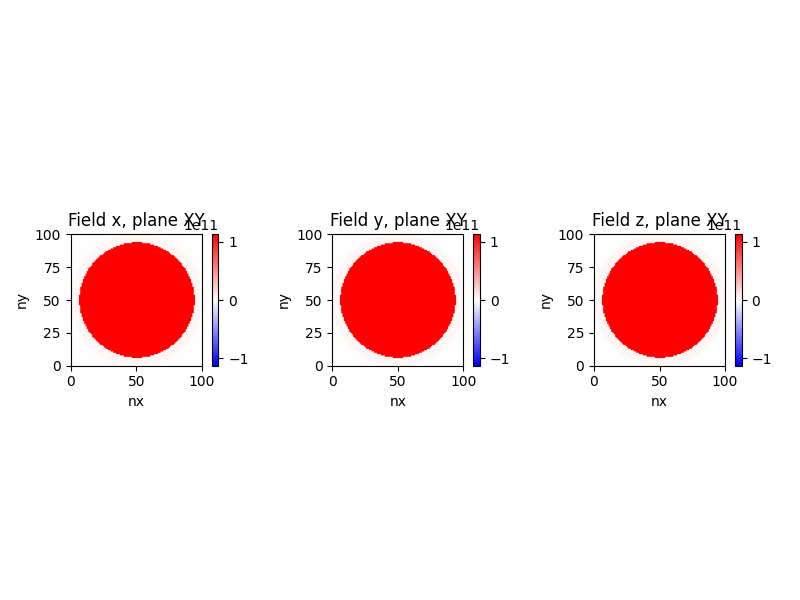

In [10]:
# Inspect the material tensors before running the simulations
solver.ieps.inspect(
    plane="XY",
)

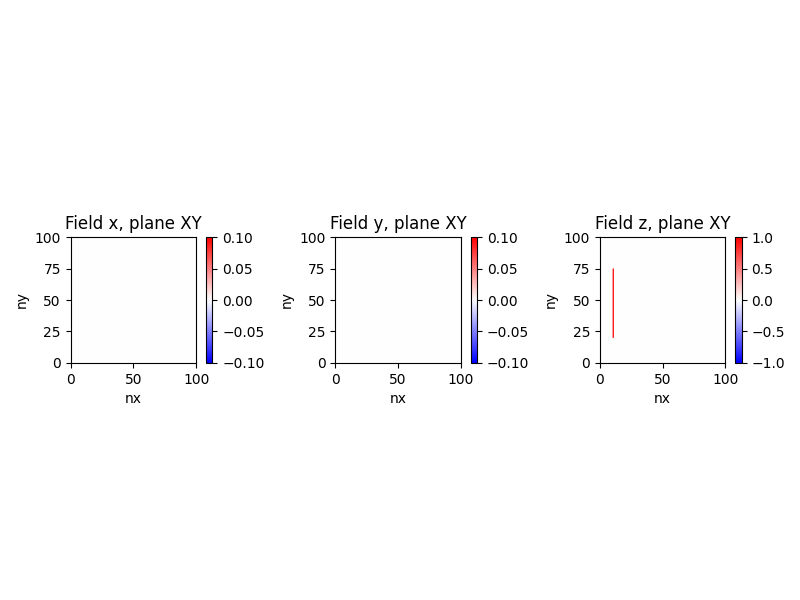

In [20]:
# Modify the field to add initial conditions and quickly inspect the modifications
solver.E[10, 20:75, :, "z"] = 1.0
solver.E.inspect(plane="XY")
solver.E[10, 20:40, :, "z"] = 0.0  # And restore it back!

### Wakefield settings & Run

The simulation beam source and wakelength is configured inside the `WakeSolver` class, that needs to be passed to the solver in order to run a Wakefield simulation

In [12]:
# ------------ Beam source ----------------
# Beam parameters
sigmaz = 10e-2  # [m] -> 2 GHz
q = 1e-9  # [C]
beta = 1.0  # beam beta
xs = 0.0  # x source position [m]
ys = 0.0  # y source position [m]
xt = 0.0  # x test position [m]
yt = 0.0  # y test position [m]
# [DEFAULT] tinj = 8.53*sigmaz/c_light  # injection time offset [s]


# ----------- Solver  setup  ----------
# Wakefield post-processor
wakelength = 60.0  # [m]
add_space = 10  # no. cells

wake = WakeSolver(
    q=q,
    sigmaz=sigmaz,
    beta=beta,
    xsource=xs,
    ysource=ys,
    xtest=xt,
    ytest=yt,
    add_space=add_space,
    results_folder="002_results/",
    Ez_file="002_results/Ez.h5",
)

Before running the wakefield simultion, we can inspect the imported solids, beam and integration paths included in the simulation:

In [16]:
pl = solver.inspect(
    wake=wake,
    opacity=1.0,
    add_silhouette=True,
    off_screen=False,
    specular=0.0,
    smooth_shading=False,
)

# If off_screen = True, we can save the scene in HTML or as a screenshot
# pl.export_html('002_inspect.html')
# pl.screenshot('002_inspect.png')

Widget(value='<iframe src="http://localhost:46189/index.html?ui=P_0x7fdfa8141d90_7&reconnect=auto" class="pyvi…

The cell bellow will run the wakefield simulation with the defined beam source and wakelength

In [ ]:
solver.wakesolve(wakelength=wakelength, wake=wake, add_space=add_space, plot=False)

### Plotting of results

Easily access the Wakefield simulation result stored in the `WakeSolver` attributes:
* Longitudinal: s, WP, Z
* Transverse: s, WPx, WPy, Zx, Zy
* Charge distribution [C/m]: s, lambdas

In [ ]:
# For scientific paper-like plots
# import scienceplots
# plt.style.use(['science','ieee'])

# Compare to benchmark data, if available
compare_to_CST = False

fig, ax = plt.subplots(1, 2, figsize=[12, 4], dpi=150)
ax[0].plot(wake.s * 1e2, wake.WP, c="r", lw=1.5, label="Wakis")
ax[0].set_xlabel("s [cm]")
ax[0].set_ylabel("Longitudinal wake potential [V/pC]", color="r")
ax[0].legend()

ax[1].plot(wake.f * 1e-9, np.abs(wake.Z), c="b", lw=1.5, label="Wakis")
ax[1].set_xlabel("f [GHz]")
ax[1].set_ylabel("Longitudinal impedance [Abs][$\Omega$]", color="b")
ax[1].legend()

if compare_to_CST:
    # CST wake and impedace data:
    cstWP = wake.read_txt("cst/WP.txt")
    cstZ = wake.read_txt("cst/Z.txt")
    ax[0].plot(cstWP[0], cstWP[1], c="k", ls="--", lw=1.5, label="CST")
    ax[1].plot(cstZ[0], cstZ[1], c="k", ls="--", lw=1.5, label="CST")
    fig.suptitle("Benchmark with CST Wakefield Solver")

fig.tight_layout()
fig.savefig("002_results/benchmark.png")

Wakefield results from previous runs can be easily loaded (longitudinal and transverse at once) using:

In [ ]:
wake.load_results(folder="002_results/")

---------------
### Running particular cases

Bellow, some other ways of running a Wakefield simulation are included, in order to showcase the flexibility and capabilities of our solver:


#### Running and 3d plotting $E_{Abs}$ on-the-fly with `solver.one_step()`

In [ ]:
from wakis.sources import Beam
from tqdm import tqdm

beam = Beam(q=q, sigmaz=sigmaz, beta=beta, xsource=xs, ysource=ys)

Nt = 3000
for n in tqdm(range(Nt)):
    beam.update(solver, n * solver.dt)

    if n % 500 == 0 and n > 3000:
        solver.plot3DonSTL(
            "E",
            component="Abs",
            cmap="rainbow",
            clim=[0, 500],
            stl_with_field="cavity",
            field_opacity=1.0,
            stl_transparent="shell",
            stl_opacity=0.1,
            stl_colors="white",
            clip_plane=True,
            clip_normal="-y",
            clip_origin=[0, 0, 0],
            off_screen=True,
            zoom=1.2,
            n=n,
            title="002_img/Ez",
        )

    solver.one_step()

#### Running with `solver.emsolve()` to calculate only EM fields
This solver routine does not compute the wake potential and the impedance and it is recommended for EM fields plotting and diagnostics

With on-the-fly 2d plotting

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list(
    "name", plt.cm.jet(np.linspace(0.1, 0.9))
)  # CST's colormap

plotkw2D = {
    "title": "002_img/Ez",
    "add_patch": ["cavity"],
    "patch_alpha": 1.0,
    "patch_reverse": True,
    "vmin": -1e3,
    "vmax": 1e3,
    "cmap": cmap,
    "plane": [int(Nx / 2), slice(0, Ny), slice(add_space, -add_space)],
}


beam = Beam(q=q, sigmaz=sigmaz, beta=beta, xsource=xs, ysource=ys)

solver.emsolve(Nt=8000, source=beam, plot=True, plot_every=100, **plotkw2D)

Or on-the-fly 3d plotting

In [ ]:
plotkw3D = {
    "title": "002_img/Ez3d",
    "add_stl": "shell",
    "field_opacity": 0.5,
}


beam = Beam(q=q, sigmaz=sigmaz, beta=beta, xsource=xs, ysource=ys)

solver.emsolve(Nt=8000, source=beam, plot3d=True, plot_every=100, **plotkw3D)